<a href="https://colab.research.google.com/github/SachinLamichhane/Tuberculosis-detection/blob/main/NeuralNetworkmetrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install beexai

In [3]:
!git clone https://github.com/SquareResearchCenter-AI/BEExAI.git

fatal: destination path 'BEExAI' already exists and is not an empty directory.


In [4]:
%cd BEExAI

/content/BEExAI


In [5]:
!pip install -r requirements.txt

In [6]:
import pandas as pd
Dataset = pd.read_csv('/content/drive/MyDrive/diabetes.csv')
Dataset.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [88]:
import yaml

# Define the configuration as a Python dictionary
config_data = {
    "path": "/content/drive/MyDrive/diabetes.csv",  # Corrected key with quotes
    "target_col": "Outcome",                       # Corrected key with quotes
    "cleaned_data_path": "/content/BEExAI/output/data/diabetes.csv",
    "task": "classification"
}

# Write the configuration to a YAML file
config_path = "/content/BEExAI/config/diabetes.yml"
with open(config_path, "w") as file:
    yaml.dump(config_data, file, default_flow_style=False)

print(f"Config file saved successfully at {config_path}")

Config file saved successfully at /content/BEExAI/config/diabetes.yml


In [89]:
import sys
sys.path.append('/content/BEExAI/src')

In [90]:
from beexai.dataset.load_data import load_data

# Define the path to the configuration file
CONFIG_PATH = "config/diabetes.yml"

# Load the dataset, target column, and task type using the configuration file
data_test, target_col, task, _ = load_data(
    from_cleaned=False,
    config_path=CONFIG_PATH,
    keep_corr_features=True
)

# Display the loaded data, target column, and task type
print("Data Test Sample:")
print(data_test.head())

print("Target Column:", target_col)
print("Task:", task)

Data Test Sample:
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  
Target Column: Outcome
Task: classification


In [91]:
import torch

from beexai.dataset.dataset import Dataset
from beexai.dataset.load_data import load_data
from beexai.evaluate.metrics.get_results import get_all_metrics
from beexai.explanation.explaining import CaptumExplainer
from beexai.training.train import Trainer
from beexai.utils.path import create_dir
from beexai.utils.sampling import stratified_sampling
from beexai.utils.time_seed import set_seed


In [124]:
seed = 42
set_seed(seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

DATA_NAME = "diabetes"
MODEL_NAME = "NeuralNetwork"

create_dir(f"/content/BEExAI/output/data")
CONFIG_PATH = f"config/{DATA_NAME}.yml"
data_test, target_col, task, dataCleaner = load_data(
    from_cleaned=True, config_path=CONFIG_PATH, keep_corr_features=True
)
scale_params = {
    "x_num_scaler_name": "quantile_normal",
    "x_cat_encoder_name": "ordinalencoder",
    "y_scaler_name": "labelencoder",
    "cat_not_to_onehot": ["name"],
}
data = Dataset(data_test, target_col)
X_train, X_test, y_train, y_test = data.get_train_test(
    test_size=0.2, scaler_params=scale_params
)
X_train, X_val, y_train, y_val = data.get_train_val(X_train, y_train, val_size=0.2)
num_labels = data.get_classes_num(task)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2667: UserWarning:

n_quantiles (1000) is greater than the total number of samples (614). n_quantiles is set to n_samples.



In [128]:
### Train a NN model
NN_PARAMS = {"input_dim": X_train.shape[1], "output_dim": num_labels}

trainer = Trainer(MODEL_NAME, task, NN_PARAMS, device)
# trainer = Trainer("XGBRegressor" ,task, device=device)
trainer.train(
    X_train.values,
    y_train.values,
    loss_file=f"../output/loss.png",
    x_val=X_val,
    y_val=y_val,
)
# trainer.model.eval()  # comment if not NN
metrics = trainer.get_metrics(X_test, y_test)
for k, v in metrics.items():
    print(f"{k}: {v}")

Loss: 0.364: 100%|██████████| 1000/1000 [04:53<00:00,  3.41it/s]

accuracy: 0.6818181818181818
f1 score: 0.6824782796383921


In [132]:
METHOD = "IntegratedGradients"
explainer = CaptumExplainer(
    trainer.model, task=task, method= METHOD, sklearn= False, device=device
)

explainer.init_explainer()
all_preds = trainer.model.predict(X_test.values)
attributions = explainer.compute_attributions(
    X_test,
    DATA_NAME,
    MODEL_NAME,
    METHOD,
    "../output/explain/",
    all_preds,
    save=True,
    use_abs=False,
)


In [133]:
import pandas as pd

# Define the list of methods to use
methods = ["Lime", "KernelShap","ShapleyValueSampling","FeatureAblation","IntegratedGradients","Saliency","DeepLift"]  # Add more methods as required

# Number of samples to test
TEST_SIZE = 300

# Stratified sampling for test set
X_test_sampled, y_test_sampled = stratified_sampling(X_test, y_test, TEST_SIZE, task)

# Initialize an empty list to collect results
metrics_list = []

# Iterate over the methods
for method in methods:
    print(f"\nRunning explanation method: {method}")

    # Initialize explainer for the current method
    exp = CaptumExplainer(
        trainer.model, task=task, method=method, sklearn=False, device=device
    )
    exp.init_explainer()

    # Compute predictions for sampled test set
    all_preds = trainer.model.predict(X_test_sampled.values)

    # Compute attributions for the current method
    attributions = exp.compute_attributions(
        X_test_sampled,
        DATA_NAME,
        MODEL_NAME,
        method,  # Use the current method
        f"../output/explain/{method}/",  # Separate folder for each method
        all_preds,
        save=False,
        use_abs=False,
    )

    # Compute metrics for the current method
    metrics = get_all_metrics(
        X_test_sampled,
        all_preds,
        trainer.model,
        exp,
        baseline="zero",
        auc_metric="mse" if task == "regression" else "accuracy",
        print_plot=False,
        save_path=None,
        device=device
    )

    # Flatten metrics if needed and add method name
    if isinstance(metrics, dict):
        metrics["Method"] = method
        metrics_list.append(metrics)
    else:
        print(f"Unexpected metrics format for {method}: {metrics}")

# Convert metrics to DataFrame
if metrics_list:
    metrics_df = pd.DataFrame(metrics_list)
    print(metrics_df)

    # Optional: Display as a styled table for Jupyter Notebooks
    from IPython.display import display
    display(metrics_df.style.set_caption("Metrics Comparison Across Methods"))
else:
    print("No metrics were collected. Please check the metrics format.")


Running explanation method: Lime


/usr/local/lib/python3.10/dist-packages/captum/attr/_core/lime.py:1115: UserWarning:

You are providing multiple inputs for Lime / Kernel SHAP attributions. This trains a separate interpretable model for each example, which can be time consuming. It is recommended to compute attributions for one example at a time.

/usr/local/lib/python3.10/dist-packages/captum/attr/_core/lime.py:1115: UserWarning:

You are providing multiple inputs for Lime / Kernel SHAP attributions. This trains a separate interpretable model for each example, which can be time consuming. It is recommended to compute attributions for one example at a time.



compute_faith_corr took 0.07891678810119629 seconds
compute_inf took 0.15093708038330078 seconds


/usr/local/lib/python3.10/dist-packages/beexai/evaluate/metrics/infidelity.py:42: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/usr/local/lib/python3.10/dist-packages/beexai/evaluate/metrics/sensitivity.py:51: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/usr/local/lib/python3.10/dist-packages/captum/attr/_core/lime.py:1115: UserWarning:

You are providing multiple inputs for Lime / Kernel SHAP attributions. This trains a separate interpretable model for each example, which can be time consuming. It is recommended to compute attributions for one example at a time.

/usr/local/lib/python3.10/dist-packages/captum/attr/_core/lime.py:1115: UserWarning:

You are providing multiple inputs fo

compute_sens took 7.877191066741943 seconds
compute_comp took 0.004114627838134766 seconds
compute_suff took 0.003610849380493164 seconds
compute_mono took 0.019916772842407227 seconds
compute_auc took 0.00678706169128418 seconds
compute_complex took 0.0013320446014404297 seconds
compute_spar took 0.0010402202606201172 seconds
Unexpected metrics format for Lime:    FaithCorr  Infidelity  Sensitivity  Comprehensiveness  Sufficiency  \
0   0.233423    0.479076     0.261069           0.348361     0.028417   

   Monotonicity    AUC_TP  Complexity  Sparseness  
0      0.857143  0.533685    0.188096    0.526709  

Running explanation method: KernelShap


/usr/local/lib/python3.10/dist-packages/captum/attr/_core/lime.py:1115: UserWarning:

You are providing multiple inputs for Lime / Kernel SHAP attributions. This trains a separate interpretable model for each example, which can be time consuming. It is recommended to compute attributions for one example at a time.

/usr/local/lib/python3.10/dist-packages/captum/attr/_core/lime.py:1115: UserWarning:

You are providing multiple inputs for Lime / Kernel SHAP attributions. This trains a separate interpretable model for each example, which can be time consuming. It is recommended to compute attributions for one example at a time.



compute_faith_corr took 0.07542920112609863 seconds
compute_inf took 0.13895463943481445 seconds


/usr/local/lib/python3.10/dist-packages/beexai/evaluate/metrics/infidelity.py:42: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/usr/local/lib/python3.10/dist-packages/beexai/evaluate/metrics/sensitivity.py:51: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/usr/local/lib/python3.10/dist-packages/captum/attr/_core/lime.py:1115: UserWarning:

You are providing multiple inputs for Lime / Kernel SHAP attributions. This trains a separate interpretable model for each example, which can be time consuming. It is recommended to compute attributions for one example at a time.

/usr/local/lib/python3.10/dist-packages/captum/attr/_core/lime.py:1115: UserWarning:

You are providing multiple inputs fo

compute_sens took 8.704533576965332 seconds
compute_comp took 0.004035472869873047 seconds
compute_suff took 0.0038099288940429688 seconds
compute_mono took 0.020256519317626953 seconds
compute_auc took 0.006735086441040039 seconds
compute_complex took 0.0013687610626220703 seconds
compute_spar took 0.0010459423065185547 seconds
Unexpected metrics format for KernelShap:    FaithCorr  Infidelity  Sensitivity  Comprehensiveness  Sufficiency  \
0   0.203867    0.455153     0.291511           0.277516     0.081178   

   Monotonicity    AUC_TP  Complexity  Sparseness  
0      0.571429  0.553977    0.219624    0.409233  

Running explanation method: ShapleyValueSampling
compute_faith_corr took 0.04853510856628418 seconds
compute_inf took 0.09134745597839355 seconds


/usr/local/lib/python3.10/dist-packages/beexai/evaluate/metrics/infidelity.py:42: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/usr/local/lib/python3.10/dist-packages/beexai/evaluate/metrics/sensitivity.py:51: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



compute_sens took 0.2800002098083496 seconds
compute_comp took 0.003916025161743164 seconds
compute_suff took 0.003509998321533203 seconds
compute_mono took 0.019604206085205078 seconds
compute_auc took 0.006560564041137695 seconds
compute_complex took 0.0013926029205322266 seconds
compute_spar took 0.0011129379272460938 seconds
Unexpected metrics format for ShapleyValueSampling:    FaithCorr  Infidelity  Sensitivity  Comprehensiveness  Sufficiency  \
0    0.39696    0.457656     0.253086           0.432107    -0.034869   

   Monotonicity    AUC_TP  Complexity  Sparseness  
0      0.571429  0.458604    0.216093    0.429061  

Running explanation method: FeatureAblation
compute_faith_corr took 0.054579973220825195 seconds
compute_inf took 0.09491872787475586 seconds
compute_sens took 0.04949498176574707 seconds
compute_comp took 0.003984689712524414 seconds
compute_suff took 0.003892183303833008 seconds
compute_mono took 0.02167797088623047 seconds
compute_auc took 0.006757020950317383

/usr/local/lib/python3.10/dist-packages/beexai/evaluate/metrics/infidelity.py:42: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/usr/local/lib/python3.10/dist-packages/beexai/evaluate/metrics/sensitivity.py:51: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



compute_faith_corr took 0.04862809181213379 seconds
compute_inf took 0.08970046043395996 seconds


/usr/local/lib/python3.10/dist-packages/beexai/evaluate/metrics/infidelity.py:42: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/usr/local/lib/python3.10/dist-packages/beexai/evaluate/metrics/sensitivity.py:51: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



compute_sens took 5.6549906730651855 seconds
compute_comp took 0.006155490875244141 seconds
compute_suff took 0.0046460628509521484 seconds
compute_mono took 0.02889561653137207 seconds
compute_auc took 0.009587526321411133 seconds
compute_complex took 0.0009436607360839844 seconds
compute_spar took 0.0006005764007568359 seconds
Unexpected metrics format for IntegratedGradients:    FaithCorr  Infidelity  Sensitivity  Comprehensiveness  Sufficiency  \
0   0.135621     0.45099     0.313165           0.252612     0.052906   

   Monotonicity    AUC_TP  Complexity  Sparseness  
0      0.714286  0.579545    0.195558    0.518861  

Running explanation method: Saliency


/usr/local/lib/python3.10/dist-packages/captum/_utils/gradient.py:57: UserWarning:

Input Tensor 0 did not already require gradients, required_grads has been set automatically.



compute_faith_corr took 0.08289337158203125 seconds
compute_inf took 0.1444094181060791 seconds
compute_sens took 0.02333378791809082 seconds
compute_comp took 0.0042684078216552734 seconds
compute_suff took 0.004102468490600586 seconds


/usr/local/lib/python3.10/dist-packages/beexai/evaluate/metrics/infidelity.py:42: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/usr/local/lib/python3.10/dist-packages/beexai/evaluate/metrics/sensitivity.py:51: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



compute_mono took 0.037055015563964844 seconds
compute_auc took 0.009998559951782227 seconds
compute_complex took 0.0012543201446533203 seconds
compute_spar took 0.0007631778717041016 seconds
Unexpected metrics format for Saliency:    FaithCorr  Infidelity  Sensitivity  Comprehensiveness  Sufficiency  \
0   0.006976    0.444789     0.249655            0.07419     0.232172   

   Monotonicity    AUC_TP  Complexity  Sparseness  
0      0.571429  0.645698    0.225083    0.386074  

Running explanation method: DeepLift


/usr/local/lib/python3.10/dist-packages/captum/_utils/gradient.py:57: UserWarning:

Input Tensor 0 did not already require gradients, required_grads has been set automatically.

/usr/local/lib/python3.10/dist-packages/captum/attr/_core/deep_lift.py:304: UserWarning:

Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished



compute_faith_corr took 0.08576846122741699 seconds
compute_inf took 0.1678318977355957 seconds


/usr/local/lib/python3.10/dist-packages/beexai/evaluate/metrics/infidelity.py:42: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/usr/local/lib/python3.10/dist-packages/beexai/evaluate/metrics/sensitivity.py:51: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



compute_sens took 0.0521695613861084 seconds
compute_comp took 0.005211830139160156 seconds
compute_suff took 0.00415349006652832 seconds
compute_mono took 0.029421329498291016 seconds
compute_auc took 0.010195255279541016 seconds
compute_complex took 0.0020644664764404297 seconds
compute_spar took 0.0013685226440429688 seconds
Unexpected metrics format for DeepLift:    FaithCorr  Infidelity  Sensitivity  Comprehensiveness  Sufficiency  \
0   0.044244    0.459098     0.264781           0.190612     0.171309   

   Monotonicity    AUC_TP  Complexity  Sparseness  
0      0.428571  0.618912    0.193934    0.525408  
No metrics were collected. Please check the metrics format.


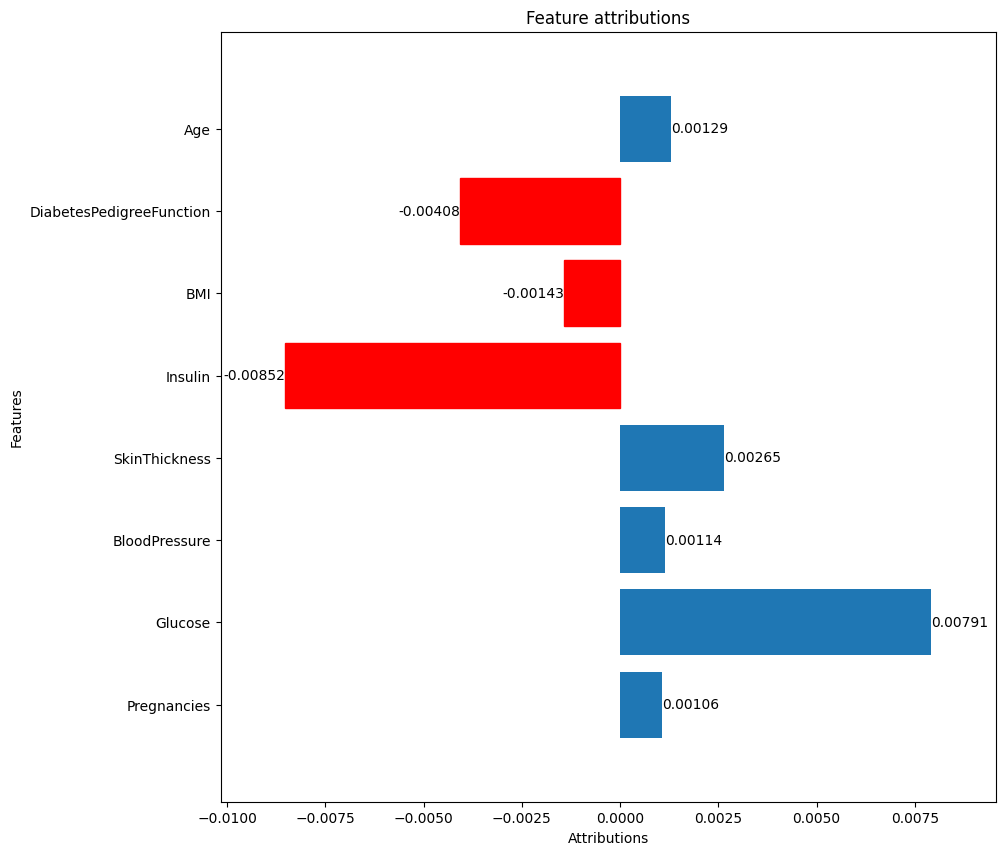

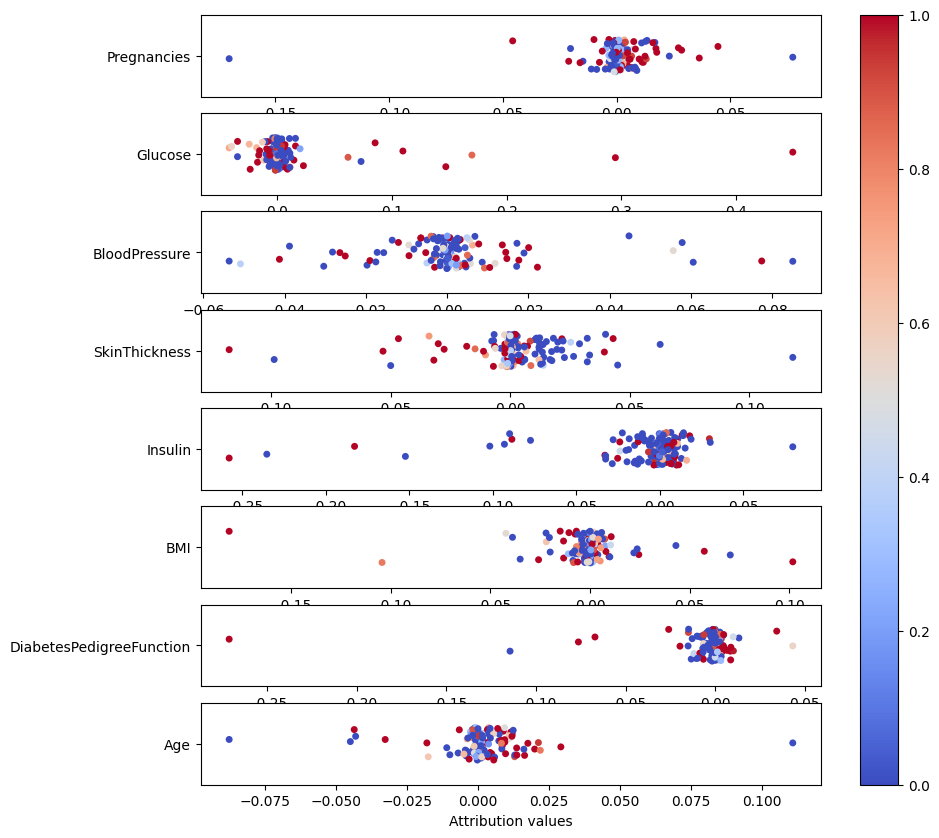

In [136]:


# Ensure attributions are converted to NumPy
attributions_np = attributions.detach().numpy() if hasattr(attributions, 'detach') else attributions

# Visualization: Bar plot, Waterfall plot, Swarm plot
bar_plot(attributions_np, feature_names=features_names, mean=True)

# Waterfall plot for a single sample
plot_waterfall(attributions_np[0], feature_names=features_names, mean=False)

# Swarm plot for the entire dataset
plot_swarm(X_test_sampled, attributions_np, feature_names=features_names)



X_test shape: (154, 8)
Sample shape: (1, 8)
Sample prediction: tensor([[1.0000e+00, 2.2806e-15]])
Initializing LIME explainer...
Explaining instance with LIME...


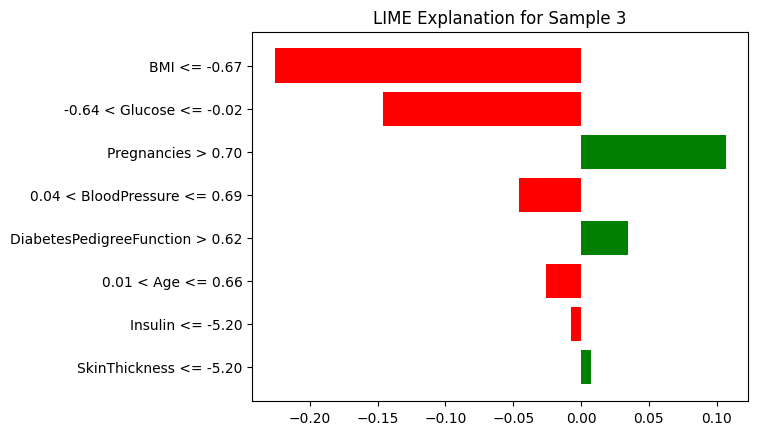

LIME explanation saved at ./output/plots/LIME_Explanation_Sample3.png
Initializing SHAP explainer...
Computing SHAP values...
SHAP values shape: (154, 8, 2)
SHAP expected value for sample 3, class 0: 0.7663716517442887
SHAP values for sample 3, class 0: .values =
array([-0.01260351,  0.07206104,  0.0463096 ,  0.08961722, -0.02700439,
        0.09701   , -0.03264558,  0.00088397])

.base_values =
0.7663716517442887

.data =
array([ 1.14344275, -0.35488549,  0.68867517, -5.19933748, -5.19933748,
       -1.08634889,  1.27145851,  0.34618911])


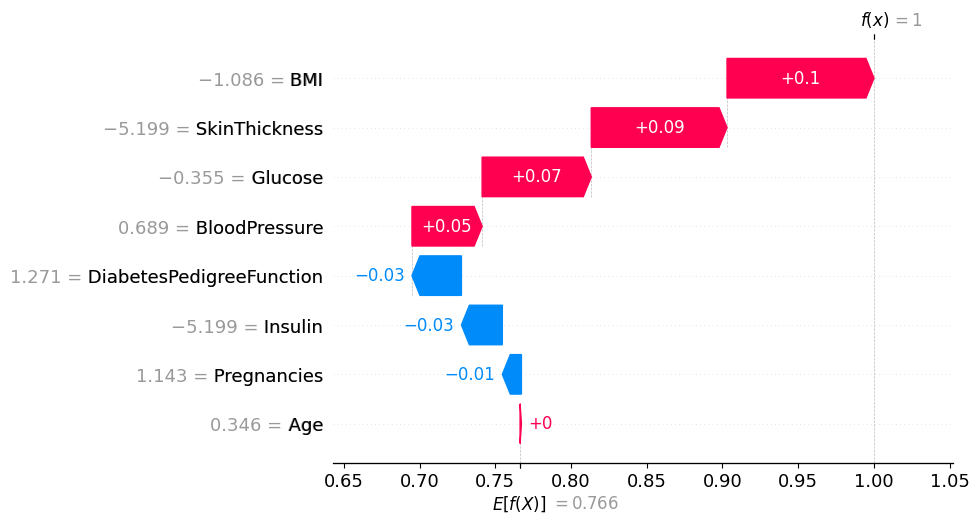

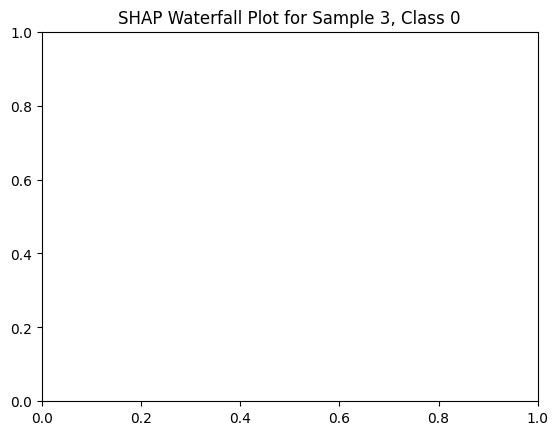

SHAP waterfall plot saved at ./output/plots/SHAP_Explanation_Sample3_Class0.png
Generating SHAP summary plot...


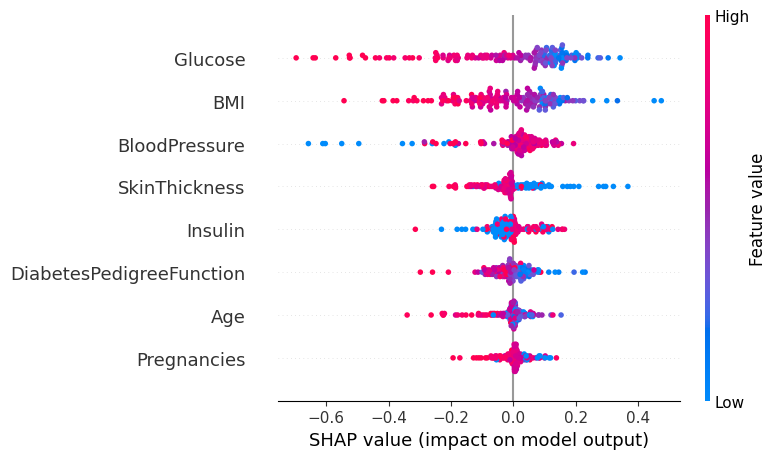

SHAP summary plot saved at ./output/plots/SHAP_Summary_Plot.png
LIME and SHAP explanations saved to ./output/plots


In [145]:
import matplotlib.pyplot as plt
import shap
from lime.lime_tabular import LimeTabularExplainer
import numpy as np
import os

# Put the model in evaluation mode
trainer.model.eval()

# Convert X_test to numpy for compatibility with LIME and SHAP
X_test_np = X_test.values
print(f"X_test shape: {X_test_np.shape}")

# Define a sample to explain
sample_index = 3  # Change this to visualize different samples
sample = X_test_np[sample_index].reshape(1, -1)
print(f"Sample shape: {sample.shape}")
sample_prediction = trainer.model.predict_proba(sample)  # Use predict_proba for classification
print(f"Sample prediction: {sample_prediction}")

# Plot directory
plot_dir = "./output/plots"
os.makedirs(plot_dir, exist_ok=True)

# LIME Explanation
print("Initializing LIME explainer...")
lime_explainer = LimeTabularExplainer(
    X_train.values,  # Training data for LIME
    feature_names=X_test.columns.tolist(),
    class_names=[f"Class {i}" for i in range(sample_prediction.shape[1])],  # Class names for classification
    mode="classification",  # Set mode to "classification"
)
print("Explaining instance with LIME...")
lime_exp = lime_explainer.explain_instance(sample.flatten(), trainer.model.predict_proba, num_features=10)

# Plot LIME Explanation
lime_plot_path = os.path.join(plot_dir, f"LIME_Explanation_Sample{sample_index}.png")
lime_exp.as_pyplot_figure()
plt.title(f"LIME Explanation for Sample {sample_index}")
plt.savefig(lime_plot_path)
plt.show()
print(f"LIME explanation saved at {lime_plot_path}")

# SHAP Explanation
print("Initializing SHAP explainer...")
shap_explainer = shap.Explainer(trainer.model.predict_proba, X_train.values)  # Use predict_proba for SHAP
print("Computing SHAP values...")
shap_values = shap_explainer(X_test_np)  # Compute SHAP values
print(f"SHAP values shape: {shap_values.shape}")

# Extract expected values for the sample and class
class_index = 0  # Change this to select a different class
expected_value = shap_values.base_values[sample_index][class_index]
print(f"SHAP expected value for sample {sample_index}, class {class_index}: {expected_value}")

# Extract SHAP values for the sample and class
sample_shap_values = shap_values[sample_index][:, class_index]
print(f"SHAP values for sample {sample_index}, class {class_index}: {sample_shap_values}")

# Plot SHAP Explanation for the sample and a specific class
shap_plot_path = os.path.join(plot_dir, f"SHAP_Explanation_Sample{sample_index}_Class{class_index}.png")
shap.waterfall_plot(
    shap.Explanation(
        values=sample_shap_values,
        base_values=expected_value,
        feature_names=X_test.columns.tolist(),
        data=X_test.iloc[sample_index].values
    )
)
plt.title(f"SHAP Waterfall Plot for Sample {sample_index}, Class {class_index}")
plt.savefig(shap_plot_path)
plt.show()
print(f"SHAP waterfall plot saved at {shap_plot_path}")

# Summary Plot for SHAP (Feature Importance for the Test Dataset)
summary_plot_path = os.path.join(plot_dir, "SHAP_Summary_Plot.png")
print("Generating SHAP summary plot...")
shap.summary_plot(
    shap_values[..., class_index],
    X_test_np,
    feature_names=X_test.columns,
    show=False
)
plt.savefig(summary_plot_path)
plt.show()
print(f"SHAP summary plot saved at {summary_plot_path}")

print(f"LIME and SHAP explanations saved to {plot_dir}")

In [146]:
print("SHAP values shape:", shap_values.shape)
print("SHAP values for the sample:", shap_values[sample_index])

SHAP values shape: (154, 8, 2)
SHAP values for the sample: .values =
array([[-0.01260351,  0.01260351],
       [ 0.07206104, -0.07206104],
       [ 0.0463096 , -0.0463096 ],
       [ 0.08961722, -0.08961722],
       [-0.02700439,  0.02700439],
       [ 0.09701   , -0.09701   ],
       [-0.03264558,  0.03264558],
       [ 0.00088397, -0.00088397]])

.base_values =
array([0.76637165, 0.23362835])

.data =
array([ 1.14344275, -0.35488549,  0.68867517, -5.19933748, -5.19933748,
       -1.08634889,  1.27145851,  0.34618911])
